# Tutorial 5b: Outliers

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t5b_outliers.ipynb). You can also view it [here](https://nbviewer.jupyter.org/url/bebi103.caltech.edu/2016/tutorials/t5b_outliers.ipynb).*

In [1]:
import collections

import numpy as np
import numba
import pandas as pd
import scipy.stats as st

import emcee
import corner
import bebi103

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

## When to throw out data

When researchers observe extreme data, they often deem them to be outliers and throw them out. They really should not do that willy nilly. It is ok to throw out data if you *know* or strongly suspect that there was something amiss in your measurement. This should be done *before* data analysis. Here are some reasons to jettison data:
* You are doing a measurement of chemical kinetics, and you note that the heatblock was set to the wrong temperature.
* You discovered when looking at the metadata that you used the wrong excitation laser in your experiment.
* You strongly suspect that you mislabeled your Eppendorf tubes.

*Sometimes* you encounter data that you should throw out during the course of data analysis. An example of this might be a time lapse microscopy run that you discover went out of focus while analyzing your images.

So, yes, there are circumstances where you should throw out measurements you have made. As a simple rule: You should only throw out data if you *know* something was wrong with the measurement or if you strongly suspect it **before** looking at the data. You should never just throw out a measurement because it is extreme.

An obvious exception to this rule is when the measurement is unphysical. For example, if you measured the a concentration of $-2$ M, you know there is something terribly wrong. In cases like these, the best bet is to suspect any data analysis and check your instrument.

## Outliers are often expected

Thus far when we have been doing regressions and other parameter estimations, we have often made the approximation that our likelihoods are Gaussian distributed.  We appeal to the central limit theorem to do this.

I think the following quote from [David MacKay's excellent book](http://www.inference.phy.cam.ac.uk/mackay/itila/book.html) is apt.

>The Gaussian distribution is widely used and often asserted to be a very common distribution in the real world, but I am sceptical about this assertion. Yes, unimodal distributions may be common; but a Gaussian is a special, rather extreme, unimodal distribution. It has very light tails: the log- probability-density decreases quadratically. The typical deviation of $x$ from $\mu$ is $\sigma$, but the respective probabilities that $x$ deviates from $\mu$ by more than 2$\sigma$, 3$\sigma$, 4$\sigma$, and 5$\sigma$, are $\small{0.046}$, $\small{0.003}$, $\small{6\times 10^{−5}}$, and $\small{6\times 10^{−7}}$. In my experience, deviations from a mean four or five times greater than the typical deviation may be rare, but not as rare as $\small{6\times 10^{−5}}$! I therefore urge caution in the use of Gaussian distributions: if a variable that is modelled with a Gaussian actually has a heavier-tailed distribution, the rest of the model will contort itself to reduce the deviations of the outliers, like a sheet of paper being crushed by a rubber band.

Yes, outliers are often expected. Extreme data are often not even the result of error in the measurement instrument, but are of great scientific interest. Nonetheless, we might expect an instrument to fail from time to time, or for there to be an error in experimental set-up that we are not able to detect that could give extreme data.

With that in mind, we might want to adjust our likelihood (i.e., our statistical model) to account for outliers. By doing this, we are being explicit in what we expect from our data. Our statistical model says that the data may very well have extreme values that may be be due to factors beyond what is controlled in the experiment. 

We will use two methods of outlier detection, both outlined in Sivia, though we will not exactly follow his prescription.  In the first method, Sivia's "Cauchy formulation" of section 8.3.3, assumed a Cauchy distribution (which has long tails) in the likelihood.  The second method is a variant on Sivia's "good-and-bad-data model," strongly influenced by example 2 of [this great blog post](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/) from Jake VanderPlas.

## Outliers in zebrafish sleep data

We will revisit the data set of Gandhi, et al., dealing with sleep in zebrafish embryos.  You may recall that we found some homozygous mutant fish that had much higher activity at night than the rest of the fish of the same genotype.  As a reminder, the original data set may be downloaded [here](../data/gandhi_et_al.zip).  We tidied the data and saved it as a CSV file.  It is probably on your machine, but if you like, you can download it [here](../data/130315_10_minute_intervals.csv).  To start with, we'll load the data into a Pandas `DataFrame` and make a bee swarm plot of the mean activity on the third night.

In [19]:
# Load DataFrame
df = pd.read_csv('../data/130315_10_minute_intervals.csv', comment='#')

# Have a look
df.head()

,fish,genotype,day,light,CLOCK,zeit,activity
0,1,het,0,True,9.819,9.819,4.500000e+00
1,1,het,0,True,9.986,9.986,6.883383e-15
2,1,het,0,True,10.153,10.153,6.883383e-15
3,1,het,0,True,10.319,10.319,6.883383e-15
4,1,het,0,True,10.486,10.486,6.883383e-15


Now, we'll compute the mean night time activity for each homozygous mutant fish on the third night.

In [20]:
# Get a view into the third night
df_n2 = df[(df['day']==2) & (df['light']==False) & (df['genotype']=='mut')]

# Compute means for each fish
mean_night_act = df_n2.groupby('fish')['activity'].mean().values

# Take a look
mean_night_act

array([  17.28333333,   18.61833333,   16.84666667,   12.16      ,
         20.585     ,  137.59333333,   12.71833333,   17.45666667,
         21.40666667,    9.705     ,   54.08833333,   16.66      ,
         33.48      ,    6.65      ,   17.89833333,  133.185     ,
         26.16833333,   28.85666667,   12.28666667,   22.83666667,
         19.095     ,   17.17166667])

Fish 21 and Fish 67 might be outliers.  This is clear also when we plot the data.

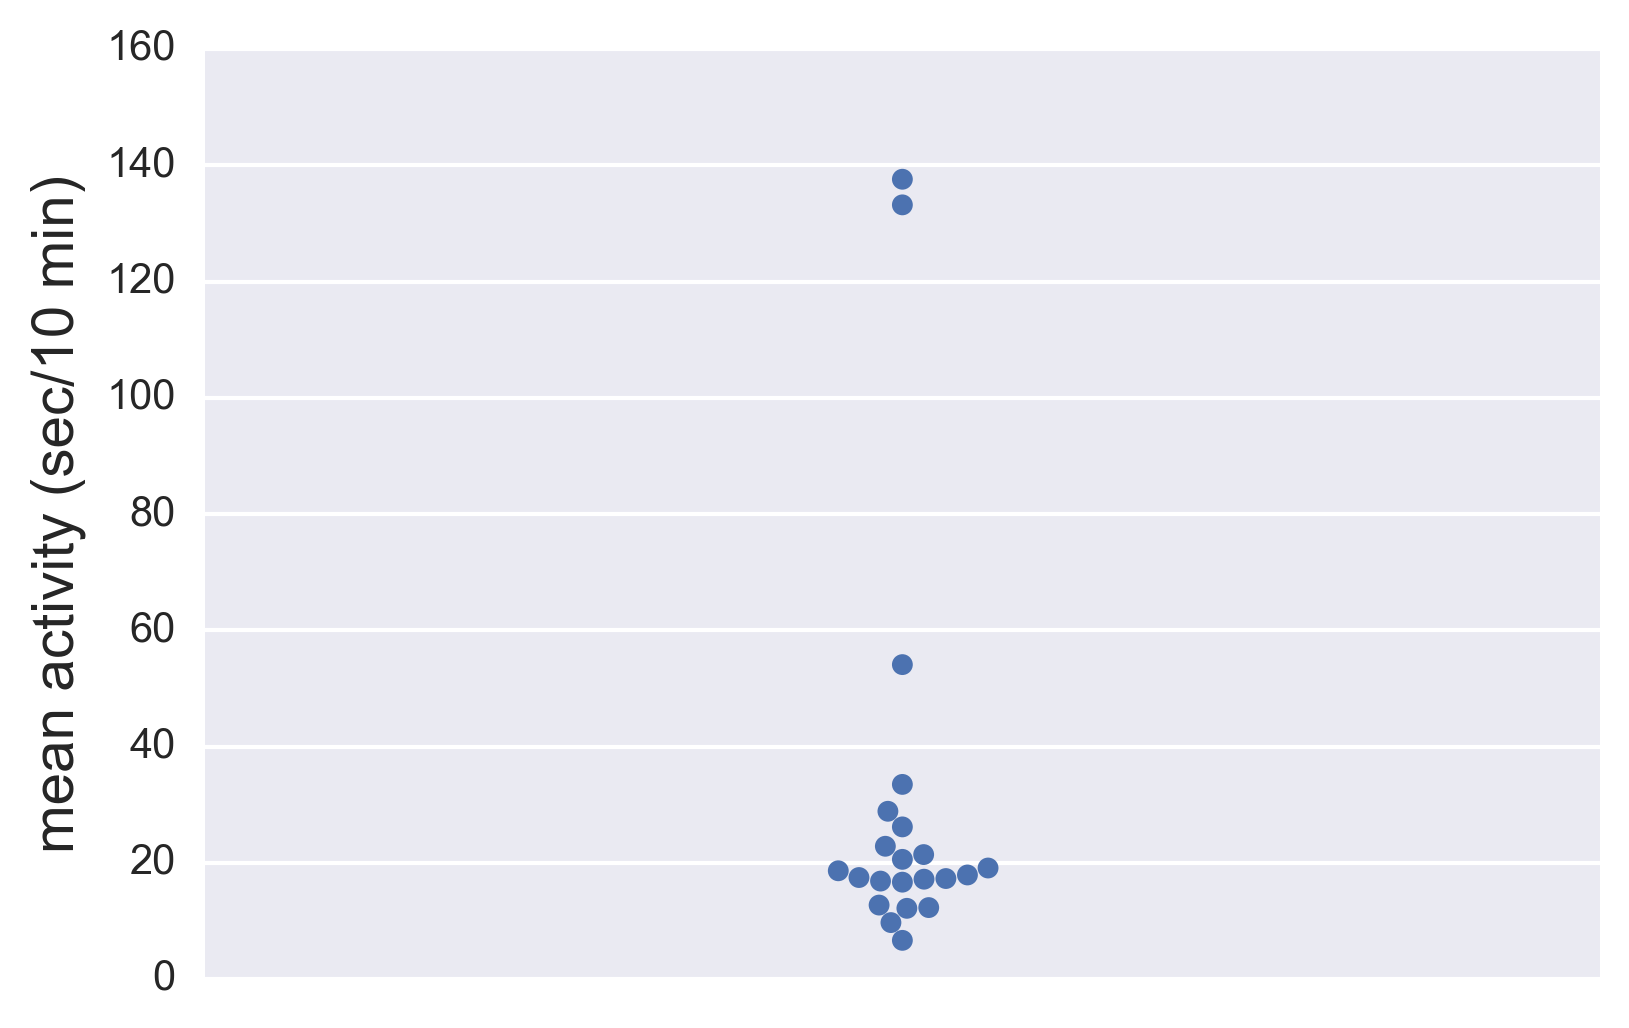

In [4]:
sns.swarmplot(y=mean_night_act)
plt.ylabel('mean activity (sec/10 min)');

Our goal is to compute the mean mean nighttime activity for this collection of fish (yes, I meant to say "mean" twice).  The naive way would be just to directly compute the mean, which we will show in red on the bee swarm plot.

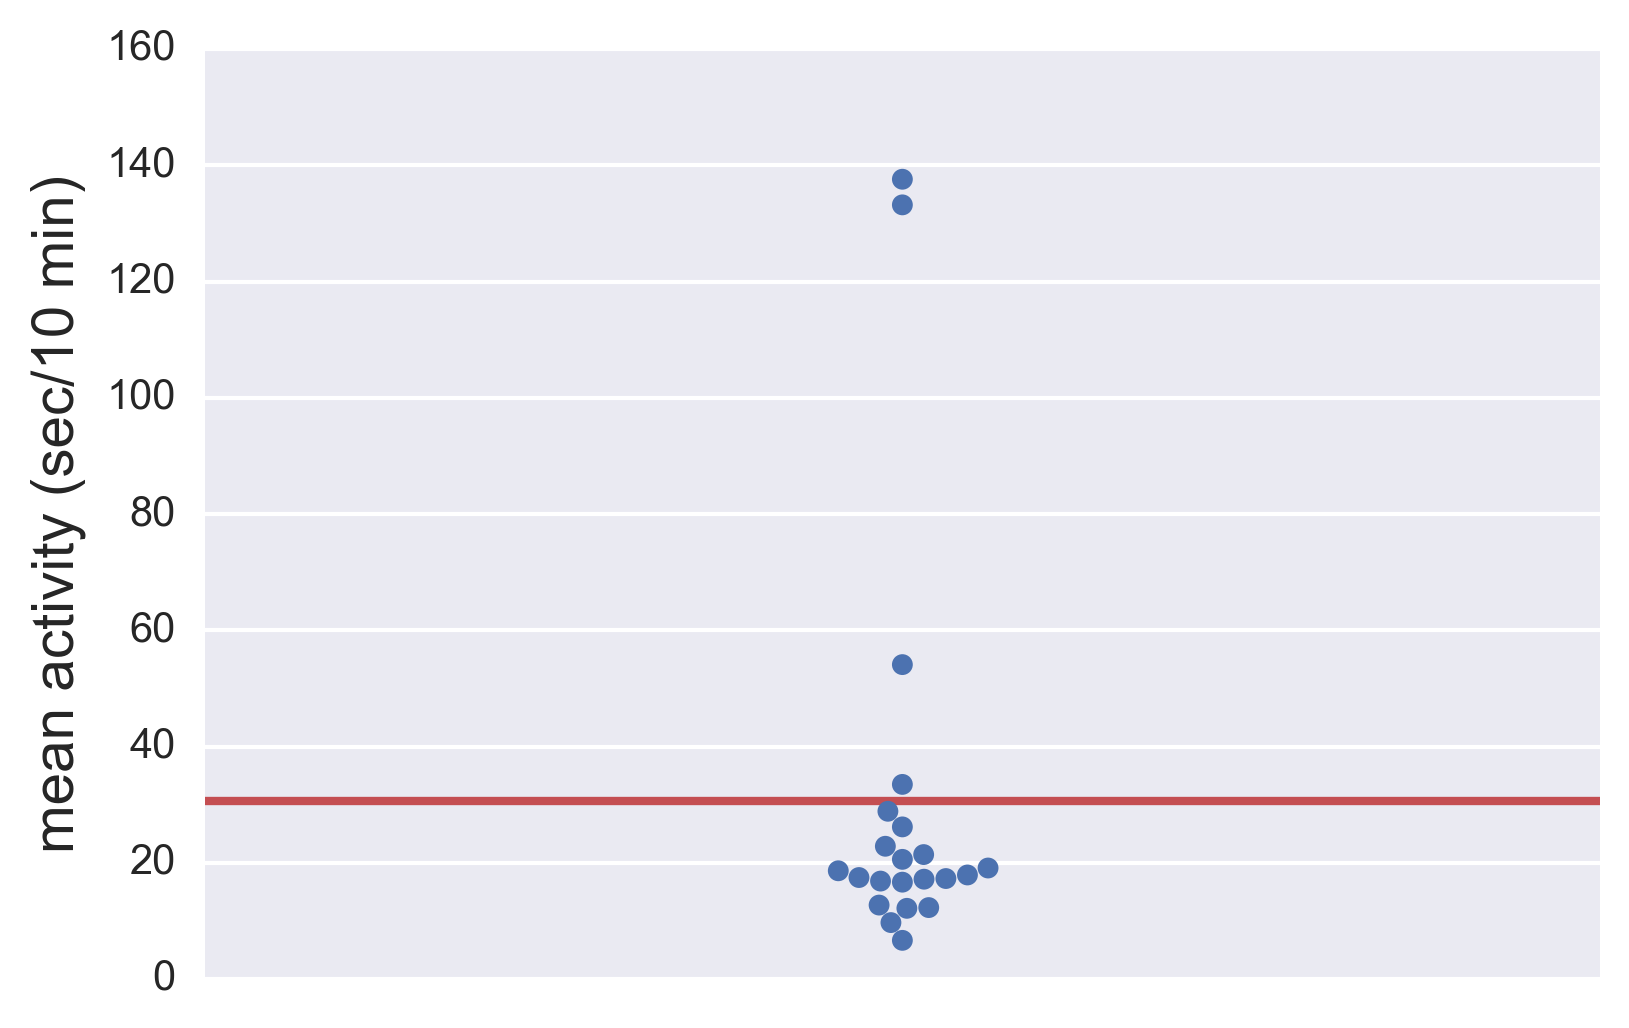

In [5]:
naive_mean = mean_night_act.mean()
sns.swarmplot(y=mean_night_act)
plt.plot(plt.gca().get_xlim(), [naive_mean, naive_mean], '-',
         color=sns.color_palette()[2])
plt.ylabel('mean activity (sec/10 min)');

The outliers tug the mean up from where we would eyeball it to be.  Note that we computed the mean as

\begin{align}
\mu = \frac{1}{n}\sum_i a_i,
\end{align}

where $a_i$ is the mean activity on the third night for fish $i$ out of $n$ total fish.  As we showed (painstakingly) in the first lecture, this is the same thing as finding the most probable value for the parameter $\mu$ when its probability distribution is

\begin{align}
P(\mu, \sigma \mid \{a_i\}, I) \propto \frac{1}{\sigma}\prod_i \frac{1}{\sqrt{2\pi\sigma^2}}\,\mathrm{e}^{-(a_i-\mu)^2/2\sigma^2}.
\end{align}

In other words, the value we calculated is the value of $\mu$ at the MAP when we have a Gaussian likelihood and a uniform prior for $\mu$ (and also a Jeffreys prior for the unknown variance in the formulation we did in lecture).

But, outliers have a strong influence on this Gaussian.  Gaussian distributions don't really allow for outliers because the tails of the distribution decrease so rapidly.  If we expect outliers, then, the Gaussian distribution is not appropriate.  The Cauchy distribution offers an alternative.  It looks Gaussian, but has very long tails.

### The Cauchy likelihood

If our *mathematical* model is that all measurements should have the same value $\mu$, then our *statistical* model specification with a Cauchy likelihood is

\begin{align}
P(\{a_i\} \mid \mu, \beta, I) = \prod_i \left[\pi\beta\left(1 + \left(\frac{a_i - \mu}{\beta}\right)^2\right)\right]^{-1}
\end{align}

We then have a posterior of

\begin{align}
P(\mu,\beta \mid \{a_i\},I) \propto \frac{1}{\beta}\prod_i \left[\pi\beta\left(1 + \left(\frac{a_i - \mu}{\beta}\right)^2\right)\right]^{-1}\,P(\mu \mid I),
\end{align}

since $\beta$ should have a Jeffreys prior.  To get the marginalized posterior, we would have to calculate

\begin{align}
\int_0^\infty \frac{\mathrm{d}\beta}{\beta}\, \prod_i \left[\pi\beta\left(1 + \left(\frac{a_i - \mu}{\beta}\right)^2\right)\right]^{-1}.
\end{align}

I did it once using contour integration in the complex plane.  It hurt.  But there is an analytical expression.  We will circumvent nasty integration using, you guessed it, MCMC.

### MCMC with a Cauchy likelihood

We now will do MCMC to find the mean of the mean activity on the third night.  We will call this parameter $\mu$.

\begin{align}
P(\mu, \beta~|~D,I) \propto \frac{1}{\beta}\prod_{i\in D} \left[\pi\beta\left(1 + \left(\frac{x_i - \mu}{\beta}\right)^2\right)\right]^{-1},
\end{align}

so

\begin{align}
\ln P(\mu, \beta~|~D,I) = \text{constant} - (n+1) \ln \beta
- \sum_{i\in D} \ln\left(1 + \left(\frac{a_i - \mu}{\beta}\right)^2\right)
\end{align}

Let's write a function for our log posterior.  We will choose a prior range for activity as $0 \le \mu \le 600$ seconds, since a fish can maximally be active for 600 seconds in a 10 minute period. We will assume a Jeffreys prior for $\beta$, and will not worry about normalization here.

In [6]:
@numba.jit(nopython=True)
def log_likelihood_cauchy(p, x):
    """
    Cauchy log likelihood.
    """
    mu, beta = p
    return -len(x) * np.log(beta) \
                    - np.sum(np.log(1.0 + ((x - mu) / beta)**2))

    
@numba.jit(nopython=True)
def log_prior_cauchy(p, mu_min, mu_max):
    """
    Log prior for fish data.
    """
    mu, beta = p
    if (not (mu_min < mu < mu_max)) or beta <= 0:
        return -np.inf
    else:
        return -np.log(beta)


@numba.jit(nopython=True)
def log_posterior_cauchy(p, x, mu_min, mu_max):
    """
    Log posterior.  
    
    x = activity levels, but can be anything we measure repeatedly.
    """
    lp = log_prior_cauchy(p, mu_min, mu_max)
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood_cauchy(p, x)

Now that we have our log posterior, we can go ahead with MCMC.

In [7]:
# Seed random number generator for reproducibility
np.random.seed(42)

# Set up parameters
p_dict = collections.OrderedDict(
        [('µ', (np.random.uniform, (10, 40,))),
         ('β', (np.random.exponential, (1,)))])

# Run MCMC
args=(mean_night_act, 0.0, 600.0)
df_mcmc = bebi103.run_ensemble_emcee(
    log_posterior_cauchy, p_dict=p_dict, args=args, n_walkers=50, 
    n_burn=5000, n_steps=5000)

Let's plot our results to take a look.

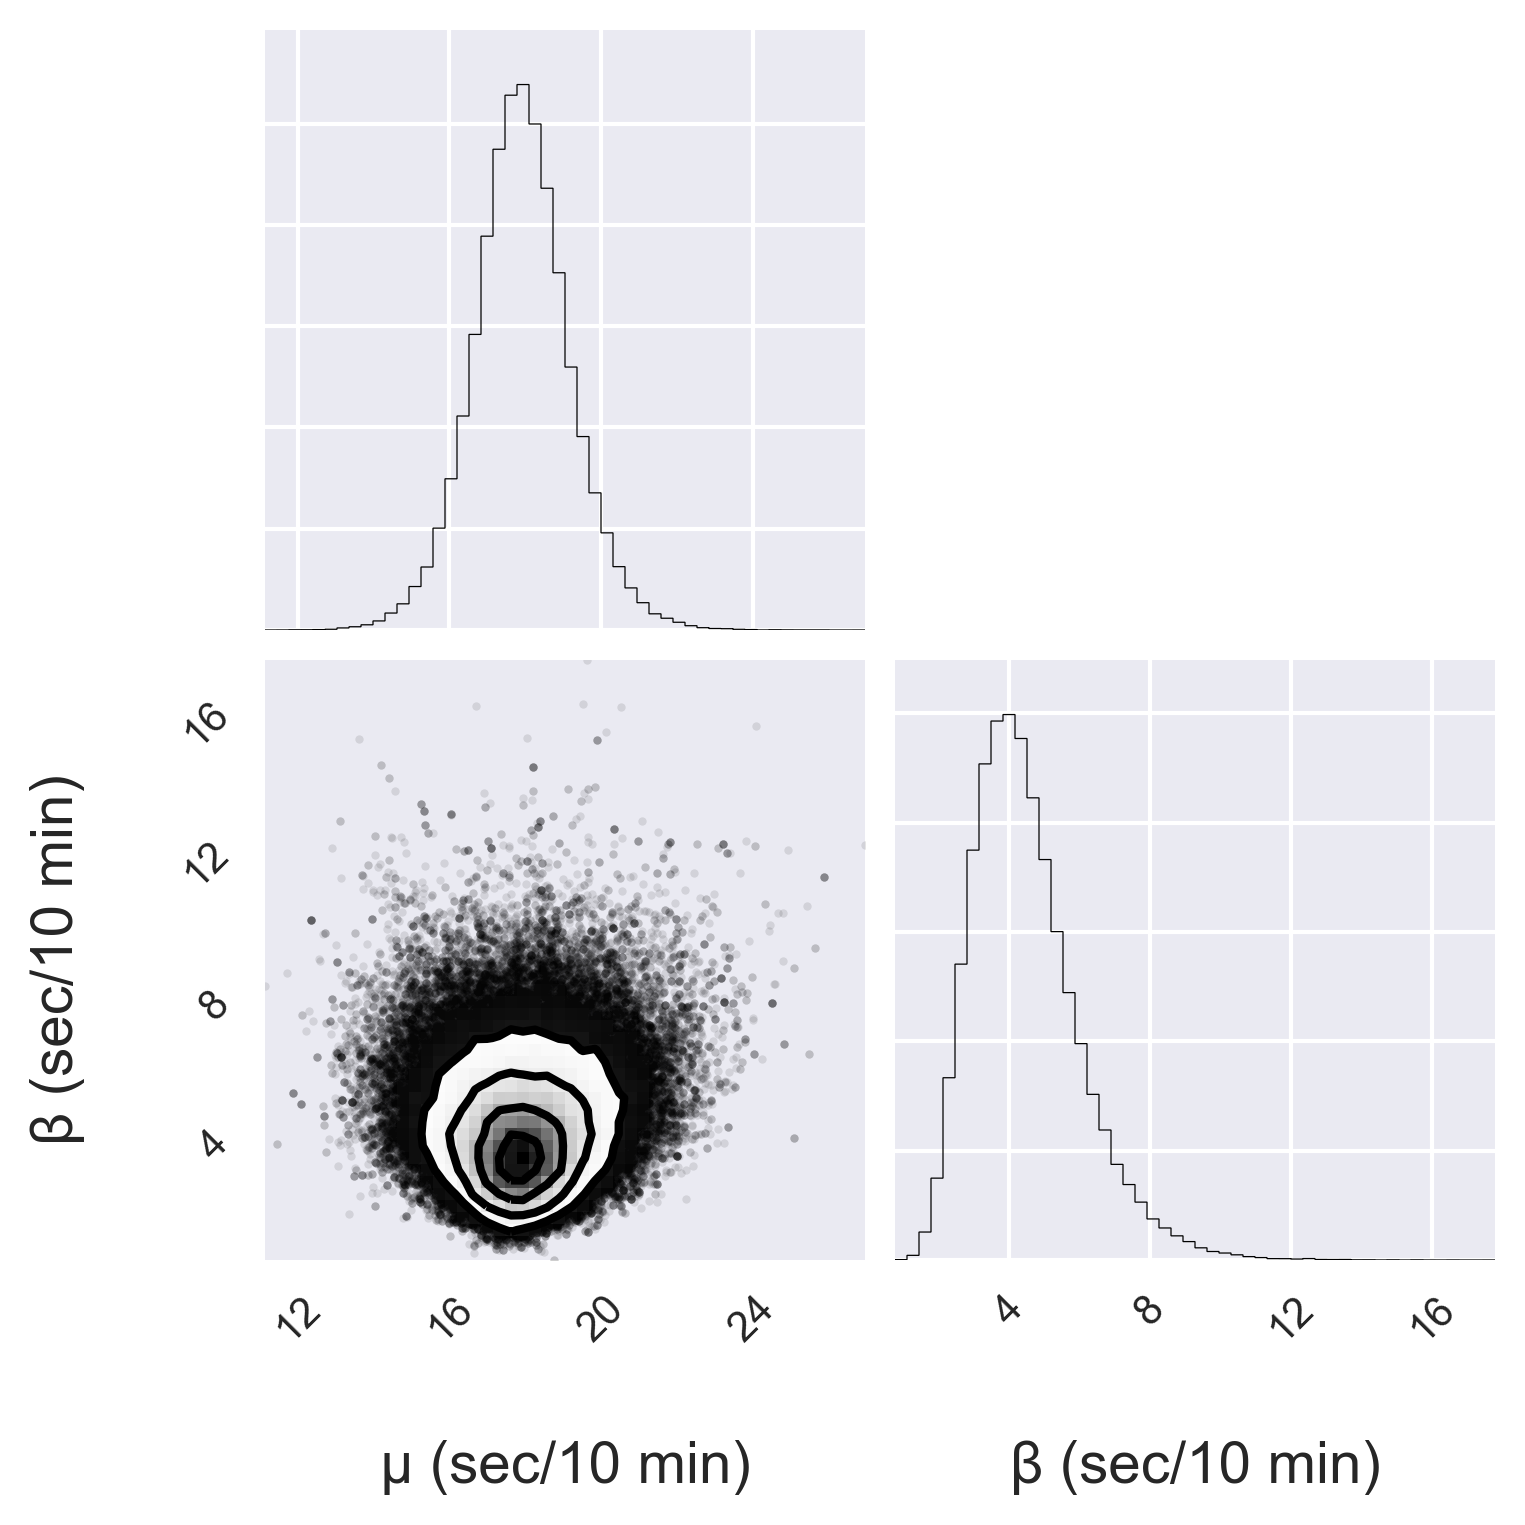

In [8]:
corner.corner(df_mcmc[['µ', 'β']], labels=['µ (sec/10 min)', 'β (sec/10 min)'],
              bins=50);

For sake of comparison with the results we are used to seeing from a Gaussian likelihood, we will assume the marginalized posterior of $\mu$ is roughly Gaussian distributed.  To check if it is, we can plot the ECDF of our samples alongside the CDF of a Gaussian with the same mean and standard deviation.

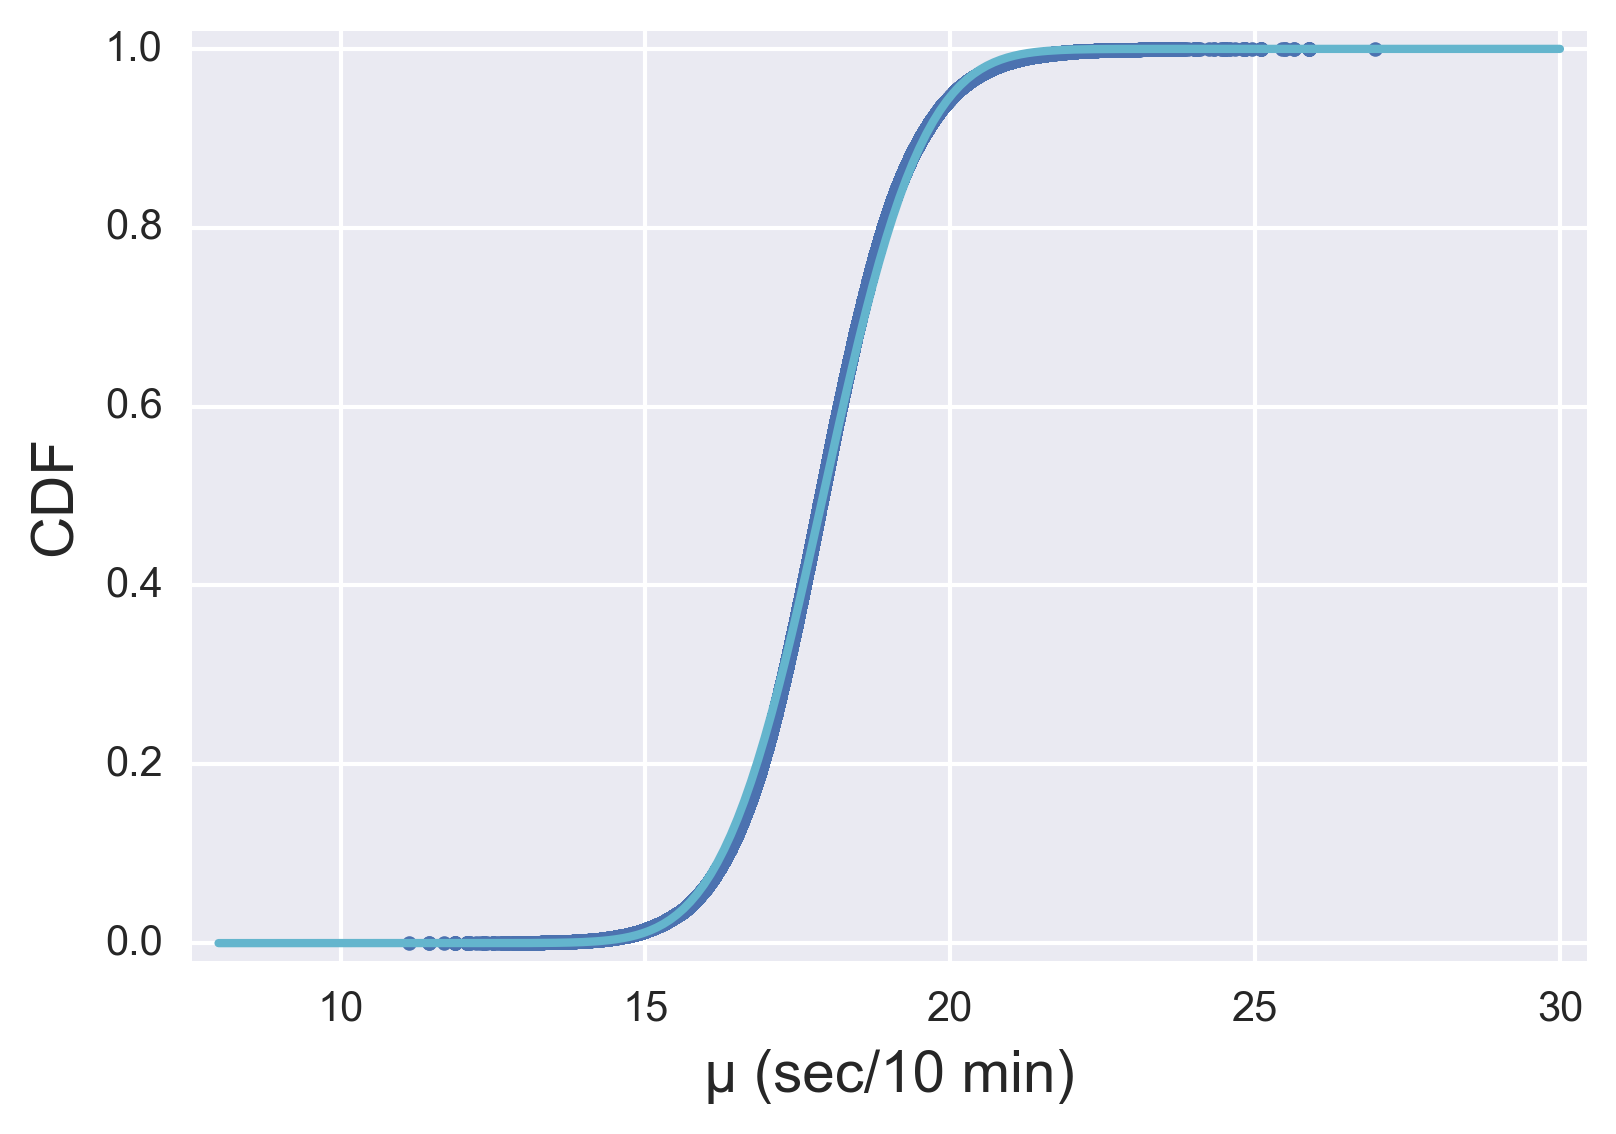

In [9]:
# Compute mean and standard deviation from traces
mu_mean = np.mean(df_mcmc['µ'])
mu_std = np.std(df_mcmc['µ'])

# Make ECDF
x, y = bebi103.ecdf(df_mcmc['µ'])

# Make Gaussian CDF
x_plot = np.linspace(8, 30, 200)
y_gauss = st.norm.cdf(x_plot, mu_mean, mu_std)

# Make plot
plt.plot(x, y, '.')
plt.plot(x_plot, y_gauss, '-', color=sns.color_palette()[5])
plt.margins(0.02)
plt.xlabel('µ (sec/10 min)')
plt.ylabel('CDF');

The posterior is quite close to being Gaussian, so we can report a mean and error bar based on directly computing the mean and standard deviation from our samples.  We can also compare using the Gaussian likelihood.

In [10]:
# Mean and SEM from Gaussian likelihood
mean_gauss = mean_night_act.mean()
sem_gauss = mean_night_act.std() / len(mean_night_act)

# Mean and SEM from Cauchy likelihood (std calc. assumes approx. Gaussian)
mean_cauchy = mu_mean
err_cauchy = mu_std

print("""
Gaussian likelihood: {0:.5f} +- {1:.5f} µm
Cauchy likelihood:   {2:.5f} +- {3:.5f} µm
""".format(mean_gauss, sem_gauss, mean_cauchy, err_cauchy))


Gaussian likelihood: 30.57955 +- 1.56728 µm
Cauchy likelihood:   17.91391 +- 1.29276 µm



The mean computed using the Cauchy method is considerably lower (and it has a smaller error bar, though this will not always be the case).  Remember, these are the results, *given that our statistical model is true*, i.e., that the data are Cauchy distributed.  That is, they are distributed in a single peak that has long tails.  

Let's make a plot again to see it qualitatively.

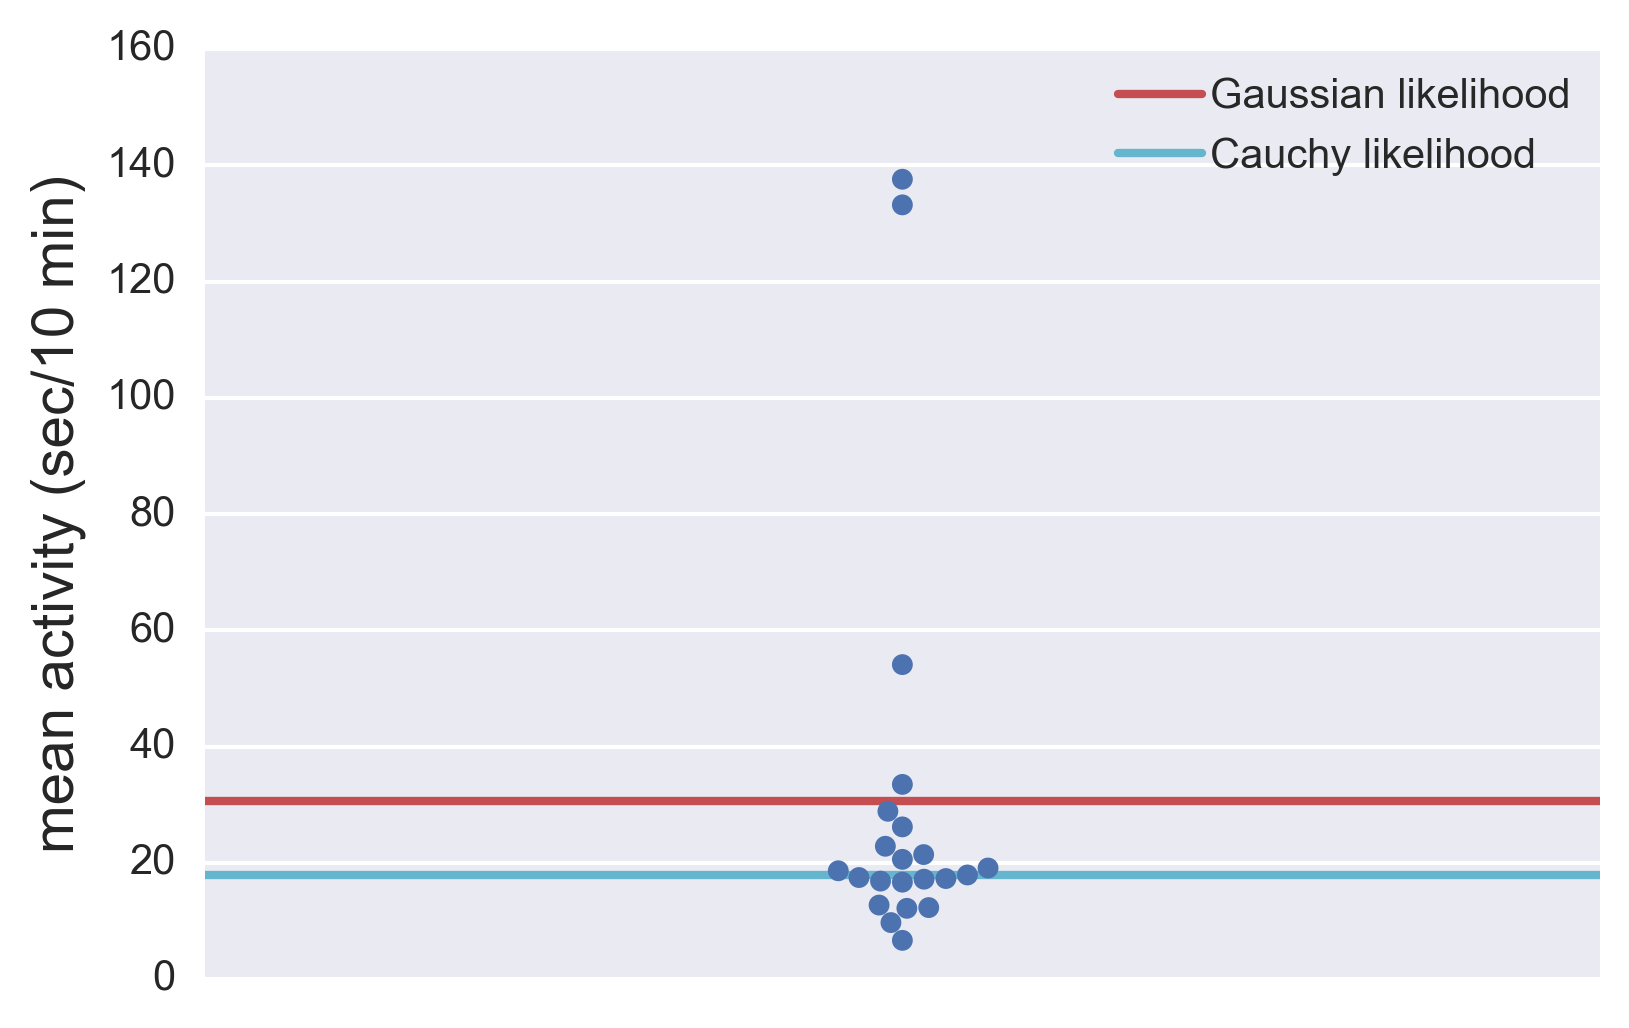

In [11]:
sns.swarmplot(y=mean_night_act)
plt.plot(plt.gca().get_xlim(), [naive_mean, naive_mean], '-',
         color=sns.color_palette()[2], label='Gaussian likelihood')
plt.plot(plt.gca().get_xlim(), [mean_cauchy, mean_cauchy], '-',
         color=sns.color_palette()[5], label='Cauchy likelihood')
plt.ylabel('mean activity (sec/10 min)')
plt.legend();

The Cauchy likelihood seems to have effectively dealt with the outliers.

## The good-and-bad data method

This section is heavily based on [this superb blog post](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/) from Jake VanderPlas, which is a nice implementation of the good-and-bad data model from section 8.3.2 of Sivia.

Let's assume for a moment that each datum can be good or bad.  We'll say that good data have an error bar of $\sigma$, and bad data have an error bar of $\sigma_\mathrm{bad}$.  Datum $i$ has a probability $g_i$ of being good.  Along with our mathematical model (all data should have a value of $\mu$), we have our statistical model and we can write the posterior.  We'll start by writing the likelihood.

\begin{align}
P(\{a_i\} \mid \mu, \sigma, \sigma_\mathrm{bad},\{g_i\}, I) &=
(2\pi)^{-n/2}\prod_i\left(
\frac{g_i}{\sigma}\,\mathrm{e}^{-(a_i-\mu)^2/2\sigma^2}
+ \frac{1-g_i}{\sigma_\mathrm{bad}}\,\mathrm{e}^{-(a_i - \mu)^2/2\sigma_\mathrm{bad}^2}
\right).
\end{align}

Then, the log posterior, assuming Jeffreys priors for $\sigma$ and $\sigma_\mathrm{bad}$ is

\begin{align}
\ln P(\mu, \sigma, \sigma_\mathrm{bad},\{g_i\} \mid \{a_i\},I) &= \text{constant}
- \ln\sigma - \ln \sigma_\mathrm{bad} \\[1em]
&\;\;\;\;- \sum_i\ln \left(\frac{g_i}{\sigma}\,\mathrm{e}^{-(a_i-\mu)^2/2\sigma^2}
+ \frac{1-g_i}{\sigma_\mathrm{bad}}\,\mathrm{e}^{-(a_i - \mu)^2/2\sigma_\mathrm{bad}^2}\right).
\end{align}

Note that this means we have a parameter, $g_i$ for every data point!  We have more parameters than data.  This might freak you out.  It shouldn't.  There is no problem with this.  We will properly marginalize everything out.

We note that the fact that $0\le g_i\le 1$ is encoded in the priors for $g_i$ and that $\sigma_\mathrm{bad} > \sigma$ is encoded in the prior for $\sigma$ and $\sigma_\mathrm{bad}$.

When we code up the log posterior, we need to be careful of numerical precision issues when computing the sum of the exponentials.  It is better to take the logs of the exponentials and then  use NumPy's `logaddexp` to do take the log of the sum of the exponentials.

In [12]:
@numba.jit(nopython=True)
def log_prior_good_bad(p, mu_min, mu_max):
    """
    Log prior for the good/bad data model.
    """
    # Pull out parameters
    mu, sigma, sigma_bad = p[:3]
    g = p[3:]
    
    # Check to make sure gi's are ok
    if (g < 0.0).any() or (g > 1.0).any():
        return -np.inf
    
    # Make sure sigma's are ok
    if not (0.0 < sigma < sigma_bad):
        return -np.inf
    
    # Check mu's
    if not (mu_min < mu < mu_max):
        return -np.inf
    
    # Jeffreys priors on sigmas
    return -np.log(sigma) - np.log(sigma_bad)


@numba.jit(nopython=True)
def log_likelihood_good_bad(p, x):
    """
    Log likelihood of the good-bad data model.
    """
    # Pull out parameters
    mu, sigma, sigma_bad = p[:3]
    g = p[3:]
    
    # Compute contributions from good and bad
    log_like_good = np.log(g / sigma) - ((x - mu) / sigma)**2 / 2.0
    log_like_bad = np.log((1.0 - g) / sigma_bad) \
                        - ((x - mu) / sigma_bad)**2 / 2.0
        
    # Return sum of result
    return np.sum(np.logaddexp(log_like_good, log_like_bad))


@numba.jit(nopython=True)
def log_posterior_good_bad(p, x, mu_min, mu_max):
    """
    Log posterior.  
    
    x = activity levels, but can be anything we measure repeatedly.
    """
    lp = log_prior_good_bad(p, mu_min, mu_max)
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood_good_bad(p, x)

Now that we have our log posterior, we can run the MCMC calculation.

In [13]:
# Seed random number generator for reproducibility
np.random.seed(42)

# Set up parameters
param_list = [('µ', (np.random.uniform, (10, 40,))),
              ('σ', (np.random.exponential, (1.0,))),
              ('σ_bad', (np.random.exponential, (20.0,)))]
g_list = [('g' + str(i), (np.random.uniform, (0.0, 1.0))) 
                          for i in range(len(mean_night_act))]
p_dict = collections.OrderedDict(param_list + g_list)

# Run MCMC
df_mcmc = bebi103.run_ensemble_emcee(
    log_posterior_good_bad, p_dict=p_dict, args=args, n_walkers=100, 
    n_burn=100000, n_steps=100000, thin=10)

/Users/Justin/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/Justin/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Let's see what we got.

In [14]:
# Get most probable parameter value
mean_goodbad = np.mean(df_mcmc['µ'])
err_goodbad = np.std(df_mcmc['µ'])

# Report results
print("""
Gaussian likelihood: {0:.2f} ± {1:.2f} sec/10 min
Cauchy likelihood:   {2:.2f} ± {3:.2f} sec/10 min
Good/bad data model: {4:.2f} ± {5:.2f} sec/10 min
""".format(mean_gauss, sem_gauss, mean_cauchy, err_cauchy, 
           mean_goodbad, err_goodbad))


Gaussian likelihood: 30.58 ± 1.57 sec/10 min
Cauchy likelihood:   17.91 ± 1.29 sec/10 min
Good/bad data model: 17.77 ± 1.68 sec/10 min



The good/bad data model and the Cauchy model gave very close to the same results.  We can't really tell the difference if we plot them.

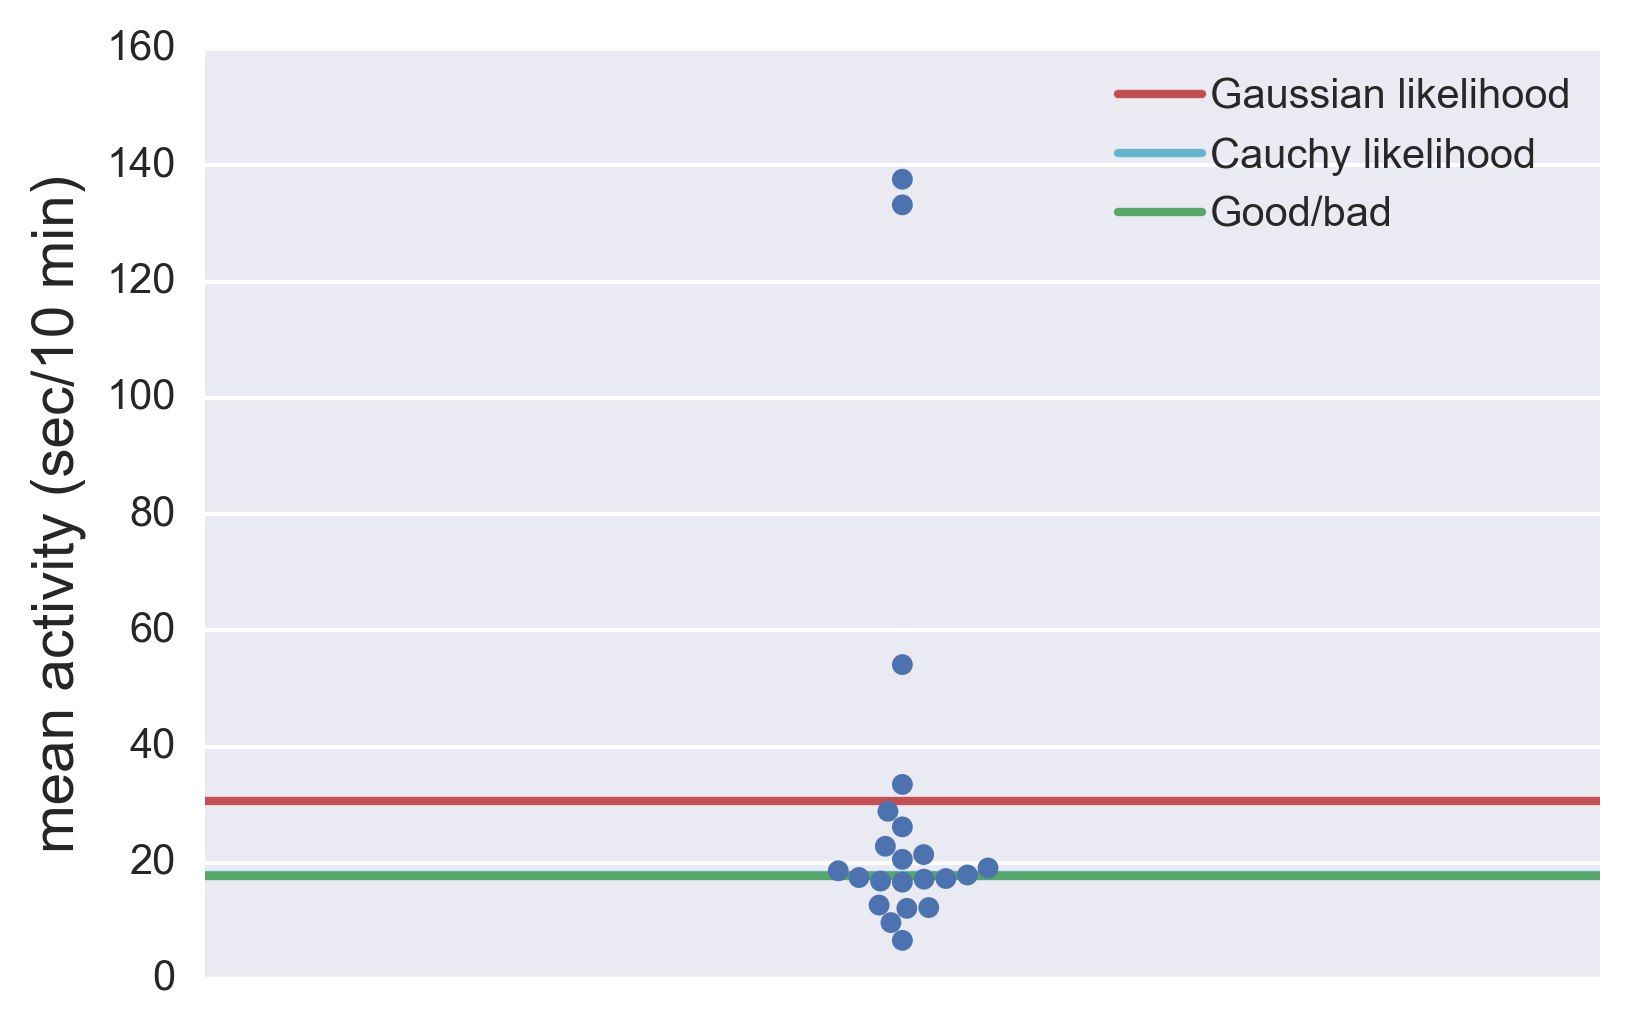

In [15]:
sns.swarmplot(y=mean_night_act)
plt.plot(plt.gca().get_xlim(), [naive_mean, naive_mean], '-',
         color=sns.color_palette()[2], label='Gaussian likelihood')
plt.plot(plt.gca().get_xlim(), [mean_cauchy, mean_cauchy], '-',
         color=sns.color_palette()[5], label='Cauchy likelihood')
plt.plot(plt.gca().get_xlim(), [mean_goodbad, mean_goodbad], '-',
         color=sns.color_palette()[1], label='Good/bad')
plt.ylabel('mean activity (sec/10 min)')
plt.legend();

A nice feature of the good/bad data model is that we can identify outliers.  Let $\bar{g}$ be the average goodness of data and $\sigma_g$ to be the standard deviation of goodness of data across all data points.  Then, we'll denote a bad data point to be one where $g_i < \bar{g} - 2\sigma_g$.

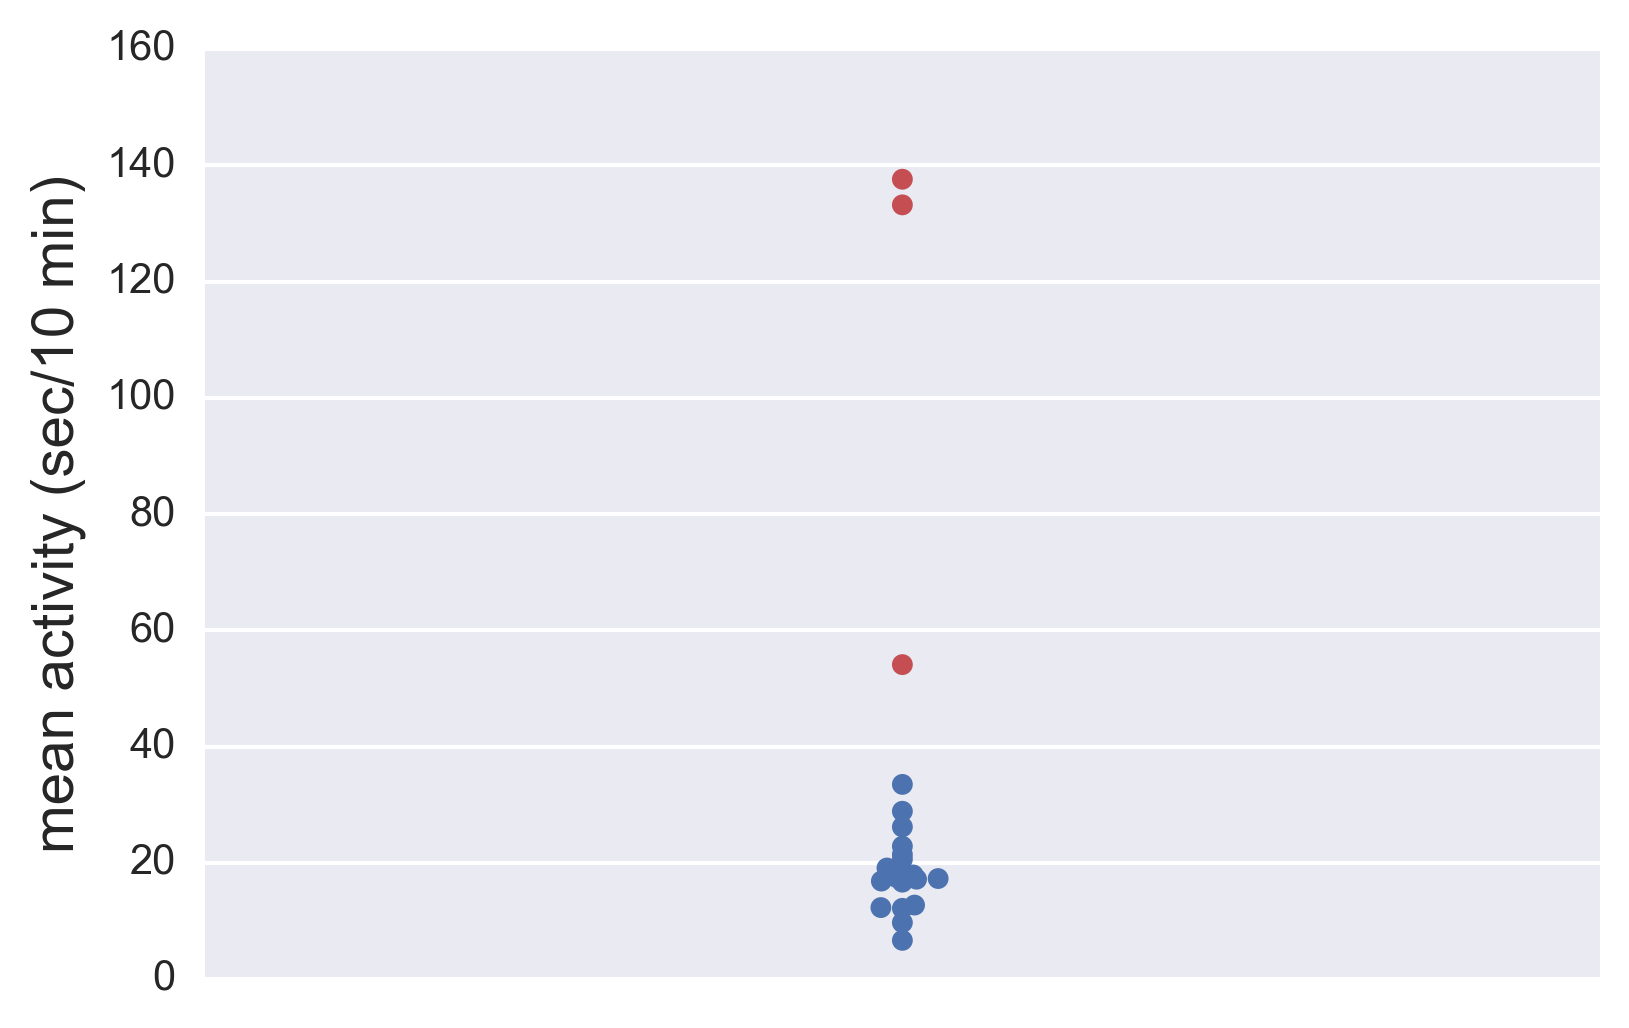

In [16]:
# Compute mean goodness of data
g = df_mcmc.loc[:, df_mcmc.columns.str.contains('g')].values.mean(axis=0)

# Identify outliers
outliers = (g < g.mean() - 2*g.std())

# Make strip plot with outliers in red
sns.swarmplot(y=mean_night_act[~outliers])
sns.swarmplot(y=mean_night_act[outliers], color=sns.color_palette()[2])
plt.ylabel('mean activity (sec/10 min)');

Finally, we can look at the distributions of $\mu$, $\sigma$, and $\sigma_\mathrm{bad}$ to get a feel for how these parameters are distributed.  All units on the axes are seconds/10 minutes.

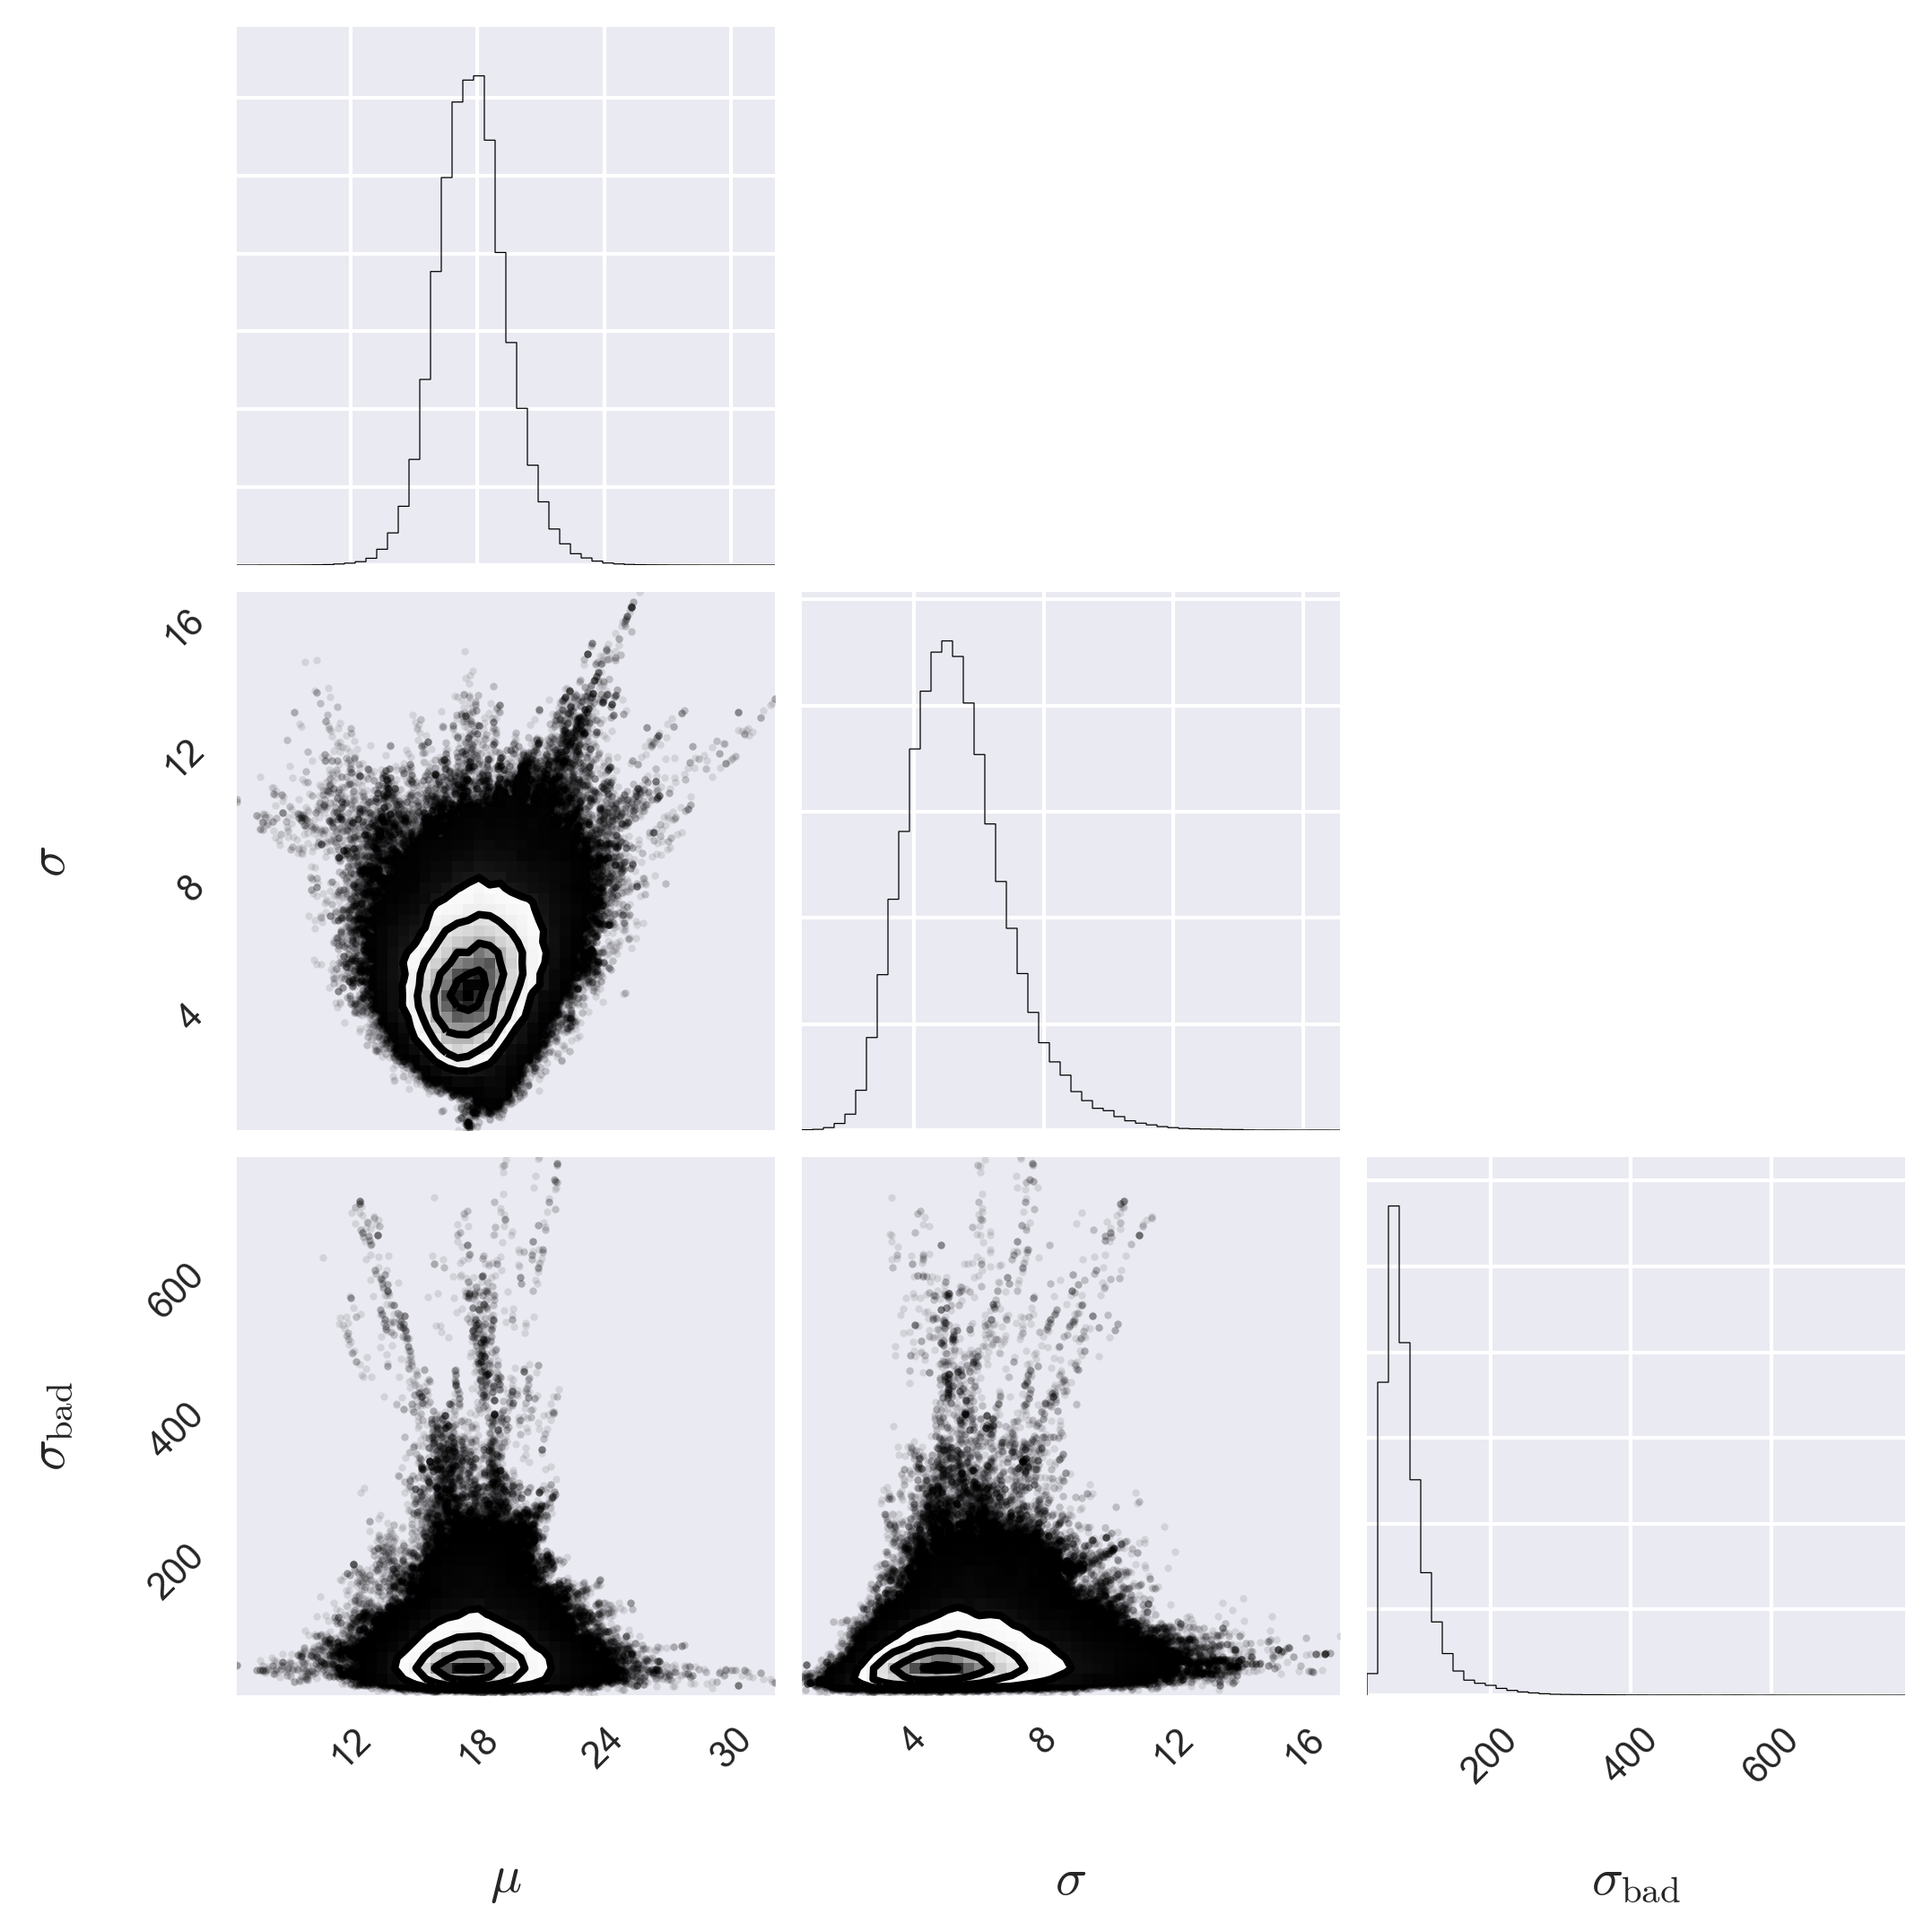

In [21]:
corner.corner(df_mcmc[['µ', 'σ', 'σ_bad']], 
              labels=[r'$\mu$', r'$\sigma$', r'$\sigma_\mathrm{bad}$'],
              bins=50);

So, $\sigma_\mathrm{bad}$ is quite large.  We also get that $\mu$ is tightly distributed around 18 sec/10 min, indicating that the effect of the outliers was mitigated.

## Extension to regression
Both the Cauchy and good/bad data methods are easily extended to work with regressions.  In both methods, we simply replace $\mu$ in the likelihood whatever function is dictated by our mathematical model.  The principles are the same, and in this case, the execution is also nearly identical.